In [126]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from util.load_scenarios import load_scenario_df
from util.load_evaluations import load_rs_df, load_ver_df

# Load data


In [127]:
RS_PATH = "../data/evaluation/random_search"

rs_df = load_rs_df(RS_PATH)

scenario_df = load_scenario_df("../data/definition/rs_routes.xml")

rs_df = rs_df.join(scenario_df, on='route_index', how='inner').sort_index()

# verification set is becoming a
ver_df = load_ver_df(RS_PATH + "/rs_v3/verification").set_index(
    'route_id')

## Load model


In [128]:

with open("model.pkl", "rb") as f:
    model = pickle.load(f)

# PROCESS DATA


## Predict fidelity robustness


In [129]:
def do_prediction(rs_trace: pd.DataFrame, model, features=['max_angles', 'dist_len_ratio', 'n_turns']) -> pd.DataFrame:
    X = rs_trace[features].to_numpy()
    rs_trace['prediciton'] = model.predict(X)
    return rs_trace

# rs_trace = do_prediction(rs_trace, model)
# rs_trace['prediciton'].value_counts()

**! very important here**
Here in 10FPS epic we have deemed 64 safe runs so they will be using low fid.
The rest of risky scenarios (686) will use high fidelity


to substitute running for risky scenario swap with 20Fid executions which is in verification set


## Fuse fidelities


In [130]:
def do_fidelity_fusion(rs_trace):
    # makes sense in case of classifier
    processed_batches = []

    # iterate over prediction classes
    for prediciton, batch in rs_trace.groupby('prediciton'):
        match prediciton:
            case 'safe':
                # do nothihg if scenario is safe to run
                batch['swapped'] = 'no'
                pass
            case 'risky':

                # use verification data set as high fidelity
                high_fid = ver_df

                # if scenario is risky swap with HF data from verification set
                high_fid = high_fid[['driving_score', 'duration_system']]
                batch = batch.drop(
                    ['driving_score', 'duration_system'], axis=1)
                batch = batch.join(high_fid, on='route_id')
                batch['swapped'] = 'yes'

        processed_batches.append(batch)

    mff_trace = pd.concat(processed_batches).sort_index()
    return mff_trace


# mff_trace = do_fidelity_fusion(rs_trace)

## Compute solutions of trace

random search


In [131]:
def get_solutions_of_iteration(rs_trace, curr_it):

    idx = pd.IndexSlice
    # get slice of data frame from iteration 0 to current iteration
    slice = rs_trace.loc[idx[:, :, :, :curr_it], :]

    # get index of minumum driving score -> solution (in iterations so far)
    gb = slice.groupby(['fps', 'highquality', 'rep',])[
        'driving_score']

    solutions_idx = gb.idxmin().rename('solution_idx')

    # get value of minimum driving score
    solutions_score = gb.min().rename('solution_score')

    solutions = pd.concat([solutions_idx, solutions_score], axis=1)
    solutions['it'] = curr_it
    solutions = solutions.reset_index().set_index(
        ['fps', 'highquality', 'rep', 'it'])

    return solutions

# get_solutions_of_iteration(mff_trace, 0)

In [132]:
def get_solutions_from_trace(rs_trace: pd.DataFrame) -> pd.DataFrame:

    NUM_OF_ITERAITONS = 25

    sols_df = pd.concat([get_solutions_of_iteration(rs_trace, it)
                        for it in range(NUM_OF_ITERAITONS)], axis=0)

    # at what iteration did we find the solution
    sols_df['solution_it'] = sols_df['solution_idx'].apply(lambda x: x[-2])
    # what is the route_id of the solution
    sols_df['solution_route_id'] = sols_df['solution_idx'].apply(
        lambda x: x[-1])

    # we don't need that once unpacked
    # sols_df = sols_df.drop('solution_idx', axis=1)

    # add data from verification
    oracle_df = ver_df['driving_score'].rename("oracle_dscore")
    sols_df = sols_df.join(oracle_df, on='solution_route_id')
    sols_df = sols_df.sort_index()
    return sols_df


# mff_sols = get_solutions_from_trace(mff_trace)

## Add cumulative time


In [133]:
def get_cumulative_time_from_trace(rs_trace: pd.DataFrame) -> pd.Series:
    cumulative_time = (rs_trace['duration_system']
                       .groupby(['fps', 'highquality', 'rep'])
                       .cumsum()
                       .rename('cumulative_time'))

    return cumulative_time


# ct = get_cumulative_time_from_trace(mff_trace)
# mff_sols = mff_sols.join(ct)
# mff_sols

## Average repetitions for a smooth curve


In [134]:
def average_repetitions(sols_df: pd.DataFrame):

    return (sols_df
            .select_dtypes('number')
            .groupby(['fps', 'highquality', 'it'])
            .mean())

# mff_sols = average_repetitions(mff_sols)

## Process search traces


In [135]:
def process_traces(traces, mff=False):

    if mff:
        # simulate multifidelity fusion using trace from 10FPS epic
        lowfid_trace = traces.copy().xs(("10", "True"), drop_level=False).sort_index()
        lowfid_trace = do_prediction(lowfid_trace, model)
        mff_trace = do_fidelity_fusion(lowfid_trace)
        traces = mff_trace

    # get solutions at each iterations
    sols_df = get_solutions_from_trace(traces)

    # calculate cumulative time of iterations
    cumulative_time = get_cumulative_time_from_trace(traces)
    sols_df = sols_df.join(cumulative_time)

    # average repetitions
    sols_df = average_repetitions(sols_df)
    return sols_df

In [136]:
# MAIN
rs_df = rs_df.reset_index().set_index(
    ['fps', 'highquality', 'rep', 'it', 'route_id'])

old_sols_df = process_traces(rs_df)
# do the same for mff
mff_sols = process_traces(rs_df, mff=True)

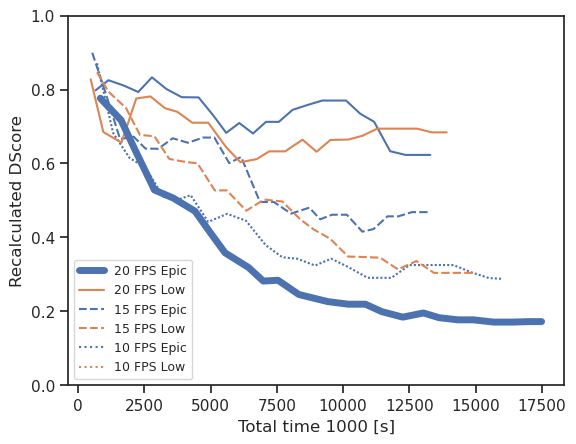

In [137]:
def plot_solutions(sols_df):
    sns.set_theme(style="ticks", palette="deep")

    f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

    sns.lineplot(data=sols_df, x='cumulative_time', y='oracle_dscore',
                 style='fps', hue='highquality', ax=ax, errorbar=None)

    sns.lineplot(data=sols_df.xs(("20", "True"), level=['fps', 'highquality'], drop_level=False),  x='cumulative_time',
                 y='oracle_dscore', hue='highquality', ax=ax,  errorbar=None, lw=5)

    ax.set_ylabel("Recalculated DScore")
    ax.set_xlabel("Total time 1000 [s]")
    ax.set_ylim(0, 1)

    # BETTER LEGEND
    handles, labels = ax.get_legend_handles_labels()

    blue = handles[1].get_color()
    orange = handles[2].get_color()
    lines = [
        mlines.Line2D([], [], color=blue, linestyle=None,
                      label='20 FPS Epic', lw=5),
        mlines.Line2D([], [], color=orange,
                      linestyle=None, label='20 FPS Low'),

        mlines.Line2D([], [], color=blue, linestyle='--', label='15 FPS Epic'),
        mlines.Line2D([], [], color=orange,
                      linestyle='--', label='15 FPS Low'),
        mlines.Line2D([], [], color=blue, linestyle='dotted',
                      label='10 FPS Epic'),
        mlines.Line2D([], [], color=orange,
                      linestyle='dotted', label='10 FPS Low'),

    ]

    ax.legend(handles=lines, prop={'size': 9})

    # f.savefig('plot_rq3.pdf', bbox_inches='tight')


plot_solutions(old_sols_df)

# PLOT


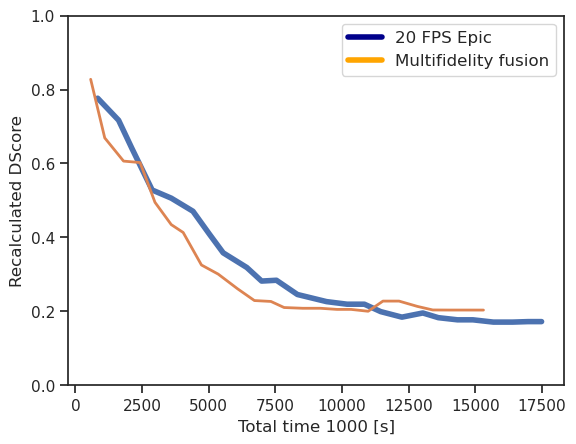

In [138]:

sns.set_theme(style="ticks", palette="deep")

f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

# sns.lineplot(data=average_sols_df(old_sols_df),  x='cumulative_time',
#              y='oracle_dscore', style='fps',  hue='highquality', ax=ax,  errorbar=None)

sns.lineplot(data=average_repetitions(old_sols_df).xs(("20", "True")),  x='cumulative_time',
             y='oracle_dscore', ax=ax,  errorbar=None, lw=4)

sns.lineplot(data=mff_sols,  x='cumulative_time',
             y='oracle_dscore', ax=ax,  errorbar=None, lw=2)


ax.set_ylabel("Recalculated DScore")
ax.set_xlabel("Total time 1000 [s]")
ax.set_ylim(0, 1)

lines = [
    mlines.Line2D([], [], color="darkblue", lw=4,
                  label='20 FPS Epic'),
    mlines.Line2D([], [], color="orange", lw=4,

                  label='Multifidelity fusion'),
]
ax.legend(handles=lines, prop={'size': 12})
f.savefig('plot.pdf', bbox_inches='tight')

## Statistical tests


In [139]:
from scipy.stats import mannwhitneyu
from itertools import permutations

In [140]:
column = 'cumulative_time'

mff_list = mff_sols[column].groupby('it').agg(list)
high_fid_list = old_sols_df.xs(("20", "True"))[column].groupby('it').agg(list)

In [141]:
def do_test(fid_a, fid_b, set_a, set_b, confidence_level=0.95):
    U1, p = mannwhitneyu(set_a, set_b)

    max_error = 1 - confidence_level

    if p < max_error:
        print(
            f"\tThe difference beetween {fid_a} and {fid_b} IS statistically significant. {p=:.5f}")
        print(set_a)
        print(set_b)
    else:
        # return
        print(
            f"\tThe difference beetween {fid_a} and {fid_b} is NOT statistically significant. {p=:.5f}")

In [142]:
# # iterate over all possible fidelities
# ITERATION = 0
# a = old_sols_df.xs(("20", "True"))
# b = sols_df.xs(("10", "True"))
# for x in b.itertuples():
#     print(x)

In [143]:
for mf, hf in zip(mff_list, high_fid_list):
    do_test("MFF", "High fid", mf, hf)

	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT statistically significant. p=1.00000
	The difference beetween MFF and High fid is NOT stati